# GEOG606 - Final Project
#### Zachary Burnett 2022-04-12

In [1707]:
from datetime import datetime
from pathlib import Path

import numpy
import pandas
from stormevents import StormEvent
import geopandas
import xarray
from geopandas import GeoDataFrame, GeoSeries
from matplotlib import pyplot
from cartopy import crs
from stormevents.coops import COOPS_Station, coops_stations

In [1708]:
data_directory = Path() / 'data'

#### retrieve NaturalEarth country boundaries

In [1709]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

## NOAA CO-OPS water level stations

In [1710]:
stations = coops_stations(station_status='active')
stations

,nws_id,name,state,status,removed,geometry
nos_id,,,,,,
1600012,46125,QREB buoy,,active,<NA>,POINT (122.62500 37.75000)
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,POINT (-177.37500 28.21875)
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,POINT (144.62500 13.44531)
1631428,PGBP7,"Pago Bay, Guam",,active,<NA>,POINT (144.75000 13.42969)
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,POINT (-170.75000 -14.27344)
...,...,...,...,...,...,...
8729840,PCLF1,Pensacola,FL,active,"2022-04-01 10:00:00,2022-04-01 00:00:00,2020-0...",POINT (-87.18750 30.40625)
8775132,LQAT2,La Quinta Channel North,TX,active,"2022-04-04 00:00:00,2022-02-18 00:00:00,2022-0...",POINT (-97.25000 27.87500)
8735180,DILA1,Dauphin Island,AL,active,"2022-04-11 23:58:00,2019-07-18 10:00:00,2018-0...",POINT (-88.06250 30.25000)


Text(0.5, 1.0, 'active NOAA CO-OPS sensor stations as of 2022-05-03')

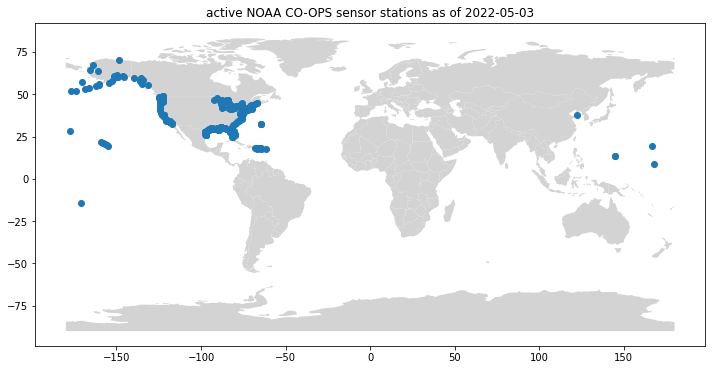

In [1711]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
stations.plot(ax=axis)
axis.set_title(f'active NOAA CO-OPS sensor stations as of {datetime.now():%Y-%m-%d}')

## Hurricane Florence (2018)

In [1712]:
storm = StormEvent('florence', 2018)
storm

StormEvent(name='FLORENCE', year=2018, start_date=Timestamp('2018-08-30 06:00:00'), end_date=Timestamp('2018-09-18 12:00:00'))

In [1713]:
best_track = storm.track(advisories=['BEST'])
best_track

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


VortexTrack('AL062018', Timestamp('2018-08-30 06:00:00'), Timestamp('2018-09-18 12:00:00'), <ATCF_FileDeck.BEST: 'b'>, [<ATCF_Advisory.BEST: 'BEST'>], None)

In [1714]:
track_bounds = numpy.stack([
    best_track.data[['longitude', 'latitude']].min().values,
    best_track.data[['longitude', 'latitude']].max().values,
], axis=1)
track_bounds[:, 0] -= 1
track_bounds[:, 1] += 1

In [1715]:
wind_swath_34kt = best_track.wind_swaths(wind_speed=34)['BEST']['20180830T060000']

Text(0.5, 1.0, 'Hurricane Florence (2018)')

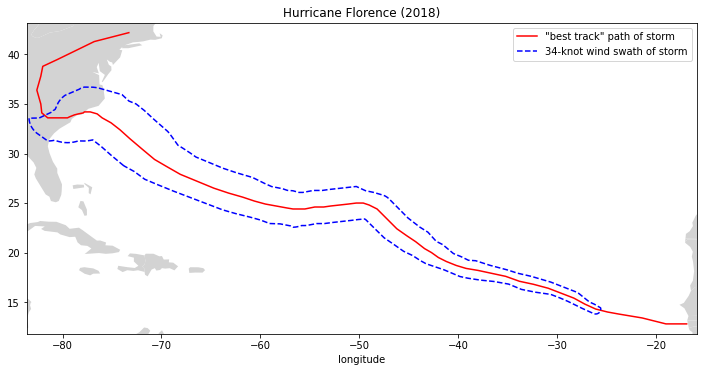

In [1716]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*track_bounds[0, :])
axis.set_ylim(*track_bounds[1, :])

best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')

axis.legend()
axis.set_title('Hurricane Florence (2018)')

### load water level data modeled by the ADCIRC oceanic circulation model during Hurricane Florence (2018) within a 34-knot wind swath of the storm's path

In [1717]:
filename = data_directory / 'run_20220502_florence2018_coopsstations' / 'runs' / 'unperturbed' / 'fort.61.nc'
modeled_water_levels = xarray.open_dataset(filename, drop_variables=['neta', 'nvel', 'max_nvdll', 'max_nvell'])
modeled_water_levels['station_name'] = modeled_water_levels['station_name'].astype(str).astype(int)
modeled_water_levels

<xarray.Dataset>
Dimensions:       (time: 1440, station: 164)
Coordinates:
  * time          (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06...
Dimensions without coordinates: station
Data variables:
    station_name  (station) int64 8726412 8726679 8726694 ... 8423898 8726667
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [1718]:
modeled_water_levels = modeled_water_levels.rename({
    'station_name': 'nos_id',
})
modeled_water_levels = modeled_water_levels.assign_coords({
    'station': modeled_water_levels['nos_id'],
    'x': modeled_water_levels['x'],
    'y': modeled_water_levels['y'],
})
modeled_water_levels = modeled_water_levels.drop(['nos_id'])
modeled_water_levels = modeled_water_levels.rename({
    'station': 'nos_id',
})
modeled_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 164)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -82.62 -82.44 -82.44 ... -81.56 -70.69 -82.44
    y        (nos_id) float64 27.66 27.92 27.94 42.31 ... 35.22 29.8 43.06 27.91
  * nos_id   (nos_id) int64 8726412 8726679 8726694 ... 8720625 8423898 8726667
Data variables:
    zeta     (time, nos_id) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [1719]:
modeled_water_levels['zeta']

<xarray.DataArray 'zeta' (time: 1440, nos_id: 164)>
[236160 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -82.62 -82.44 -82.44 ... -81.56 -70.69 -82.44
    y        (nos_id) float64 27.66 27.92 27.94 42.31 ... 35.22 29.8 43.06 27.91
  * nos_id   (nos_id) int64 8726412 8726679 8726694 ... 8720625 8423898 8726667
Attributes:
    long_name:      water surface elevation above geoid
    standard_name:  sea_surface_height_above_geoid
    units:          m

In [1720]:
stations_bounds = numpy.array([
    [modeled_water_levels['x'].min(), modeled_water_levels['x'].max()],
    [modeled_water_levels['y'].min(), modeled_water_levels['y'].max()],
])
stations_bounds[:, 0] -= 1
stations_bounds[:, 1] += 1
stations_bounds

array([[-84.875   , -66.      ],
       [ 24.734375,  45.90625 ]])

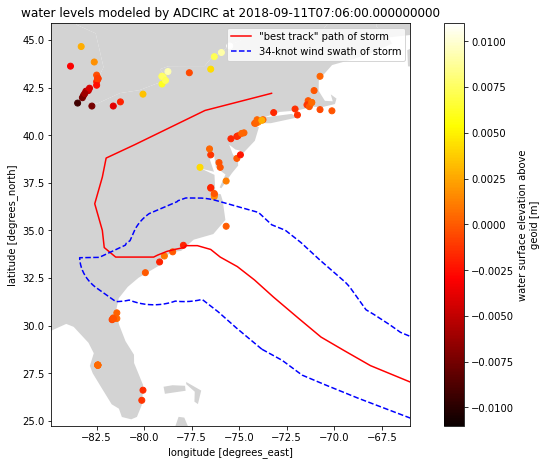

In [1721]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

modeled_water_levels_at_selected_time = modeled_water_levels.isel(time=10)
modeled_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='zeta', cmap='hot', ax=axis)
axis.set_title(f'water levels modeled by ADCIRC at {modeled_water_levels_at_selected_time["time"].values}')

axis.legend()

### retrieve water level data observed by NOAA CO-OPS during Hurricane Florence (2018) within the 34-knot isotach of the storm

In [1722]:
observed_water_levels_filename = data_directory / 'florence2018_east_coast_water_levels.nc'

if not observed_water_levels_filename.exists():
    stations = [
        COOPS_Station(float(nos_id.values))
        for nos_id in modeled_water_levels['nos_id']
    ]
    data = [
        station.product(
            'water_level',
            start_date=pandas.to_datetime(min(modeled_water_levels['time']).values),
            end_date=pandas.to_datetime(max(modeled_water_levels['time']).values),
            units='metric',
        )
        for station in stations
    ]
    data = [
        entry for entry in data
        if numpy.product(list(entry.sizes.values())) > 0
    ]
    observed_water_levels = xarray.combine_by_coords(data)
    observed_water_levels.to_netcdf(observed_water_levels_filename)
else:
    observed_water_levels = xarray.open_dataset(observed_water_levels_filename)

observed_water_levels = observed_water_levels.rename({'t': 'time'})
observed_water_levels['v'] /= 100
observed_water_levels['s'] /= 100

observed_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 111)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object ...
    x        (nos_id) float64 ...
    y        (nos_id) float64 ...
Data variables:
    v        (nos_id, time) float32 0.7427 0.7427 0.7427 ... 1.769 1.769 1.769
    s        (nos_id, time) float32 1e-05 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    f        (nos_id, time) object ...
    q        (nos_id, time) object ...

In [1723]:
observed_water_levels['v']

<xarray.DataArray 'v' (nos_id: 111, time: 1440)>
array([[0.7427    , 0.74267995, 0.74267   , ..., 0.74274004, 0.74273   ,
        0.74274004],
       [0.74541   , 0.74542   , 0.74544   , ..., 0.74524003, 0.74523   ,
        0.74527   ],
       [0.06736   , 0.06604   , 0.0647    , ..., 0.03643   , 0.03762   ,
        0.03877   ],
       ...,
       [1.7694    , 1.76951   , 1.76966   , ..., 1.76923   , 1.76908   ,
        1.7690899 ],
       [1.76933   , 1.76925   , 1.76934   , ..., 1.7690899 , 1.76932   ,
        1.76929   ],
       [1.76996   , 1.7699499 , 1.76996   , ..., 1.7692399 , 1.7692101 ,
        1.76916   ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### normalize observed water levels by subtracting the time average for each station

In [1724]:
observed_water_levels['normalized_v'] = observed_water_levels['v'] - observed_water_levels['v'].mean(dim='time')
observed_water_levels['normalized_v']

<xarray.DataArray 'normalized_v' (nos_id: 111, time: 1440)>
array([[-1.9383430e-04, -2.1386147e-04, -2.2381544e-04, ...,
        -1.5377998e-04, -1.6379356e-04, -1.5377998e-04],
       [ 1.2898445e-04,  1.3893843e-04,  1.5896559e-04, ...,
        -4.1007996e-05, -5.1021576e-05, -1.1026859e-05],
       [ 2.3347914e-02,  2.2027917e-02,  2.0687915e-02, ...,
        -7.5820871e-03, -6.3920841e-03, -5.2420832e-03],
       ...,
       [-1.1432171e-04, -4.2915344e-06,  1.4567375e-04, ...,
        -2.8431416e-04, -4.3427944e-04, -4.2438507e-04],
       [-5.9247017e-05, -1.3923645e-04, -4.9233437e-05, ...,
        -2.9933453e-04, -6.9260597e-05, -9.9301338e-05],
       [ 1.5783310e-04,  1.4770031e-04,  1.5783310e-04, ...,
        -5.6231022e-04, -5.9211254e-04, -6.4218044e-04]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### compare modeled water levels vs observed water levels

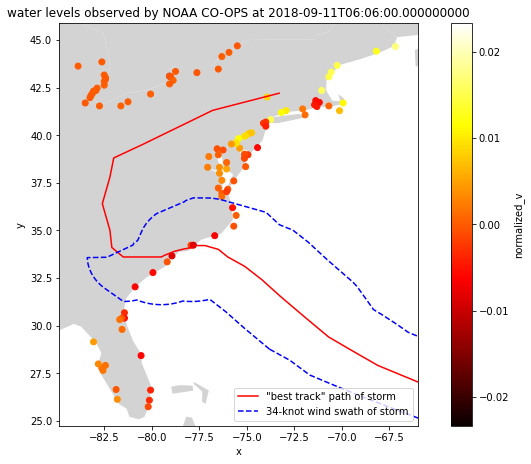

In [1725]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

observed_water_levels_at_selected_time = observed_water_levels.isel(time=0)
observed_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='normalized_v', cmap='hot', ax=axis)
axis.set_title(f'water levels observed by NOAA CO-OPS at {observed_water_levels_at_selected_time["time"].values}')

axis.legend()

Text(0.5, 1.0, 'water levels observed by NOAA CO-OPS at each station')

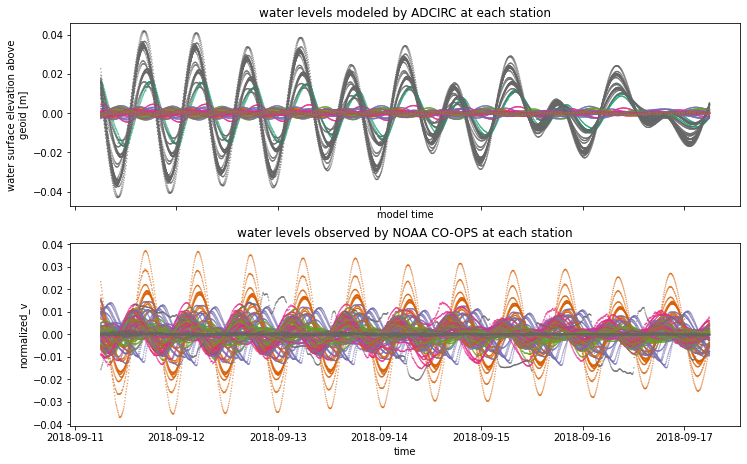

In [1726]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis_1, axis_2 = figure.subplots(2, 1, sharex='all')

modeled_water_levels.plot.scatter(x='time', y='zeta', hue='nos_id', cmap='Dark2', add_guide=False, s=0.1, ax=axis_1)
observed_water_levels.plot.scatter(x='time', y='normalized_v', hue='nos_id', cmap='Dark2', add_guide=False, s=0.1, ax=axis_2)

axis_1.set_title('water levels modeled by ADCIRC at each station')
axis_2.set_title('water levels observed by NOAA CO-OPS at each station')

In [1727]:
rmse = ((modeled_water_levels['zeta'] - observed_water_levels['normalized_v']) ** 2).mean(dim='time') ** 0.5
rmse = rmse.assign_coords({'x': modeled_water_levels['x'], 'y': modeled_water_levels['y']})
rmse

<xarray.DataArray (nos_id: 111)>
array([0.01782234, 0.02122448, 0.01121045, 0.01793502, 0.01753038,
       0.01689731, 0.00812301, 0.01749603, 0.01124193, 0.00730455,
       0.01689529, 0.01680871, 0.01799165, 0.00468935, 0.0169243 ,
              nan,        nan, 0.01786649, 0.00779452, 0.0127035 ,
              nan,        nan, 0.01125253, 0.01685899, 0.01669584,
              nan, 0.01723463,        nan, 0.00481909, 0.0067749 ,
              nan, 0.00127126, 0.00220683, 0.01052025, 0.00891012,
              nan, 0.0055307 , 0.00463058,        nan,        nan,
       0.00387329,        nan, 0.00309756, 0.00700547, 0.00256312,
              nan,        nan,        nan, 0.00698584,        nan,
              nan, 0.00349018,        nan, 0.00588406,        nan,
       0.00221199,        nan, 0.00408149,        nan, 0.01146401,
              nan,        nan, 0.00686308,        nan,        nan,
       0.00411503,        nan, 0.01691696, 0.01344044, 0.00459068,
       0.01844508, 0.00189445, 0.00382725,        nan,        nan,
              nan,        nan, 0.00344044, 0.00707517,        nan,
              nan, 0.01832917, 0.01053653, 0.00688951, 0.00591529,
              nan, 0.00534835,        nan,        nan, 0.00238842,
       0.01049492,        nan, 0.00730655, 0.00693863, 0.0082316 ,
              nan, 0.00504715,        nan,        nan, 0.00308989,
       0.0163808 , 0.00224177,        nan, 0.00911724, 0.00242339,
       0.00825563,        nan,        nan,        nan,        nan,
              nan])
Coordinates:
  * nos_id   (nos_id) int64 9044036 9075035 9052076 ... 8720625 8423898 8726667
    nws_id   (nos_id) object 'FWNM4' 'ESVM4' 'OCTN6' ... 'RCYF1' 'FTPN3' 'MCYF1'
    y        (nos_id) float64 42.31 43.62 43.34 42.09 ... 37.03 29.8 43.06 27.91
    x        (nos_id) float64 -83.06 -83.88 -78.75 ... -81.56 -70.69 -82.44

<AxesSubplot:xlabel='nos_id'>

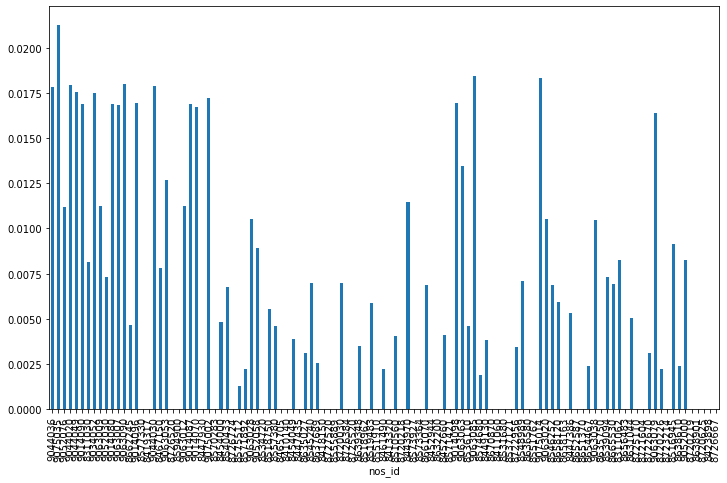

In [1728]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

rmse.to_series().plot.bar(ax=axis)

## calculate spatial auto-correlation of the RMSE values

In [1729]:
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
from shapely.geometry import Polygon, MultiPoint

### build Voronoi regions from points

In [1730]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [1731]:
voronoi_regions = Voronoi(numpy.stack([rmse['x'], rmse['y']], axis=1))
voronoi_regions

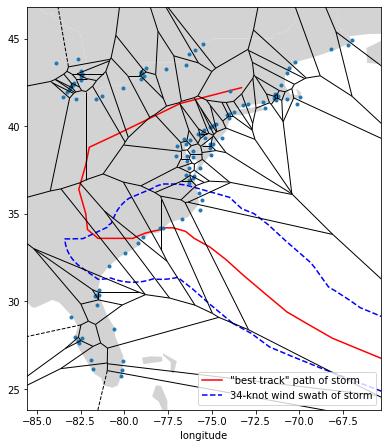

In [1732]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

voronoi_plot_2d(
    voronoi_regions,
    color='darkgrey',
    show_points=True,
    show_vertices=False,
    ax=axis,
)

axis.legend()

### attach these voronoi regions to the RMSE dataset

In [1733]:
polygons = {}
for region_index, region in enumerate(voronoi_regions.regions):
    if region_index in voronoi_regions.point_region:
        point_indices = voronoi_regions.point_region[voronoi_regions.point_region == region_index]
        points = voronoi_regions.points[[index for index in point_indices if index != -1]]
        point = points[0, :]
        entry = rmse.where(
            (rmse['x'] == point[0]) &
            (rmse['y'] == point[1]),
            drop=True,
        )
        polygon = Polygon([voronoi_regions.vertices[vertex_index] for vertex_index in region if vertex_index != -1])
        polygons[int(entry['nos_id'][0].values)] = polygon
polygons = GeoSeries(polygons)
polygons

9044036    POLYGON ((-71.484 53.896, 157.097 -123.362, -6...
9075035    POLYGON ((-80.959 26.446, -65.503 24.627, -60....
9052076    POLYGON ((-80.970 26.054, 157.097 -123.362, -7...
9044020    POLYGON ((-66.982 41.707, -67.901 45.387, -71....
9044049    POLYGON ((-66.982 41.707, -67.901 45.387, 157....
                                 ...                        
9052000    POLYGON ((-76.259 37.176, -76.734 36.859, -76....
8720219    POLYGON ((-75.895 36.614, -76.757 35.797, -77....
8638901    POLYGON ((-75.895 36.614, -76.757 35.797, -76....
8720625    POLYGON ((-76.248 37.202, -76.231 37.341, -76....
8423898    POLYGON ((-76.259 37.176, -76.734 36.859, -78....
Length: 107, dtype: geometry

In [1734]:
rmse_dataframe = rmse.to_dataframe(name='rmse')
rmse_dataframe = GeoDataFrame(rmse_dataframe, geometry=geopandas.points_from_xy(rmse_dataframe['x'], rmse_dataframe['y']))
rmse_dataframe = rmse_dataframe.loc[polygons.index]
rmse_dataframe = rmse_dataframe[~pandas.isna(rmse_dataframe['rmse'])]
rmse_dataframe

,nws_id,y,x,rmse,geometry
9044036,FWNM4,42.31250,-83.0625,0.017822,POINT (-83.06250 42.31250)
9075035,ESVM4,43.62500,-83.8750,0.021224,POINT (-83.87500 43.62500)
9052076,OCTN6,43.34375,-78.7500,0.011210,POINT (-78.75000 43.34375)
9044020,GRTM4,42.09375,-83.1875,0.017935,POINT (-83.18750 42.09375)
9044049,WMPM4,42.34375,-82.9375,0.017530,POINT (-82.93750 42.34375)
...,...,...,...,...,...
9063079,MRHO1,41.53125,-82.7500,0.016381,POINT (-82.75000 41.53125)
8720226,MSBF1,30.31250,-81.6875,0.002242,POINT (-81.68750 30.31250)
8516945,KPTN6,40.81250,-73.7500,0.009117,POINT (-73.75000 40.81250)
8638610,SWPV2,36.93750,-76.3125,0.002423,POINT (-76.31250 36.93750)


In [1735]:
rmse_dataframe['region'] = polygons
rmse_dataframe

,nws_id,y,x,rmse,geometry,region
9044036,FWNM4,42.31250,-83.0625,0.017822,POINT (-83.06250 42.31250),"POLYGON ((-71.484 53.896, 157.097 -123.362, -6..."
9075035,ESVM4,43.62500,-83.8750,0.021224,POINT (-83.87500 43.62500),"POLYGON ((-80.959 26.446, -65.503 24.627, -60...."
9052076,OCTN6,43.34375,-78.7500,0.011210,POINT (-78.75000 43.34375),"POLYGON ((-80.970 26.054, 157.097 -123.362, -7..."
9044020,GRTM4,42.09375,-83.1875,0.017935,POINT (-83.18750 42.09375),"POLYGON ((-66.982 41.707, -67.901 45.387, -71...."
9044049,WMPM4,42.34375,-82.9375,0.017530,POINT (-82.93750 42.34375),"POLYGON ((-66.982 41.707, -67.901 45.387, 157...."
...,...,...,...,...,...,...
9063079,MRHO1,41.53125,-82.7500,0.016381,POINT (-82.75000 41.53125),"POLYGON ((-71.328 41.609, -71.428 41.709, -71...."
8720226,MSBF1,30.31250,-81.6875,0.002242,POINT (-81.68750 30.31250),"POLYGON ((-71.600 41.246, -71.699 41.339, -71...."
8516945,KPTN6,40.81250,-73.7500,0.009117,POINT (-73.75000 40.81250),"POLYGON ((-71.600 41.246, -71.699 41.339, -72...."
8638610,SWPV2,36.93750,-76.3125,0.002423,POINT (-76.31250 36.93750),"POLYGON ((-76.259 37.176, -76.141 36.859, -75...."


In [1736]:
rmse_dataframe['point'] = rmse_dataframe['geometry']
rmse_dataframe

,nws_id,y,x,rmse,geometry,region,point
9044036,FWNM4,42.31250,-83.0625,0.017822,POINT (-83.06250 42.31250),"POLYGON ((-71.484 53.896, 157.097 -123.362, -6...",POINT (-83.06250 42.31250)
9075035,ESVM4,43.62500,-83.8750,0.021224,POINT (-83.87500 43.62500),"POLYGON ((-80.959 26.446, -65.503 24.627, -60....",POINT (-83.87500 43.62500)
9052076,OCTN6,43.34375,-78.7500,0.011210,POINT (-78.75000 43.34375),"POLYGON ((-80.970 26.054, 157.097 -123.362, -7...",POINT (-78.75000 43.34375)
9044020,GRTM4,42.09375,-83.1875,0.017935,POINT (-83.18750 42.09375),"POLYGON ((-66.982 41.707, -67.901 45.387, -71....",POINT (-83.18750 42.09375)
9044049,WMPM4,42.34375,-82.9375,0.017530,POINT (-82.93750 42.34375),"POLYGON ((-66.982 41.707, -67.901 45.387, 157....",POINT (-82.93750 42.34375)
...,...,...,...,...,...,...,...
9063079,MRHO1,41.53125,-82.7500,0.016381,POINT (-82.75000 41.53125),"POLYGON ((-71.328 41.609, -71.428 41.709, -71....",POINT (-82.75000 41.53125)
8720226,MSBF1,30.31250,-81.6875,0.002242,POINT (-81.68750 30.31250),"POLYGON ((-71.600 41.246, -71.699 41.339, -71....",POINT (-81.68750 30.31250)
8516945,KPTN6,40.81250,-73.7500,0.009117,POINT (-73.75000 40.81250),"POLYGON ((-71.600 41.246, -71.699 41.339, -72....",POINT (-73.75000 40.81250)
8638610,SWPV2,36.93750,-76.3125,0.002423,POINT (-76.31250 36.93750),"POLYGON ((-76.259 37.176, -76.141 36.859, -75....",POINT (-76.31250 36.93750)


In [1737]:
rmse_dataframe = GeoDataFrame(
    rmse_dataframe,
    geometry=rmse_dataframe['region'],
)
rmse_dataframe

,nws_id,y,x,rmse,geometry,region,point
9044036,FWNM4,42.31250,-83.0625,0.017822,"POLYGON ((-71.484 53.896, 157.097 -123.362, -6...","POLYGON ((-71.484 53.896, 157.097 -123.362, -6...",POINT (-83.06250 42.31250)
9075035,ESVM4,43.62500,-83.8750,0.021224,"POLYGON ((-80.959 26.446, -65.503 24.627, -60....","POLYGON ((-80.959 26.446, -65.503 24.627, -60....",POINT (-83.87500 43.62500)
9052076,OCTN6,43.34375,-78.7500,0.011210,"POLYGON ((-80.970 26.054, 157.097 -123.362, -7...","POLYGON ((-80.970 26.054, 157.097 -123.362, -7...",POINT (-78.75000 43.34375)
9044020,GRTM4,42.09375,-83.1875,0.017935,"POLYGON ((-66.982 41.707, -67.901 45.387, -71....","POLYGON ((-66.982 41.707, -67.901 45.387, -71....",POINT (-83.18750 42.09375)
9044049,WMPM4,42.34375,-82.9375,0.017530,"POLYGON ((-66.982 41.707, -67.901 45.387, 157....","POLYGON ((-66.982 41.707, -67.901 45.387, 157....",POINT (-82.93750 42.34375)
...,...,...,...,...,...,...,...
9063079,MRHO1,41.53125,-82.7500,0.016381,"POLYGON ((-71.328 41.609, -71.428 41.709, -71....","POLYGON ((-71.328 41.609, -71.428 41.709, -71....",POINT (-82.75000 41.53125)
8720226,MSBF1,30.31250,-81.6875,0.002242,"POLYGON ((-71.600 41.246, -71.699 41.339, -71....","POLYGON ((-71.600 41.246, -71.699 41.339, -71....",POINT (-81.68750 30.31250)
8516945,KPTN6,40.81250,-73.7500,0.009117,"POLYGON ((-71.600 41.246, -71.699 41.339, -72....","POLYGON ((-71.600 41.246, -71.699 41.339, -72....",POINT (-73.75000 40.81250)
8638610,SWPV2,36.93750,-76.3125,0.002423,"POLYGON ((-76.259 37.176, -76.141 36.859, -75....","POLYGON ((-76.259 37.176, -76.141 36.859, -75....",POINT (-76.31250 36.93750)


In [1738]:
rmse_dataframe = rmse_dataframe.clip(
    MultiPoint(rmse_dataframe['point'].tolist()).convex_hull,
)
rmse_dataframe

,nws_id,y,x,rmse,geometry,region,point
9075035,ESVM4,43.625000,-83.8750,0.021224,"POLYGON ((-79.96059 26.32808, -80.12500 26.078...","POLYGON ((-80.95919 26.44557, -65.50344 24.627...",POINT (-83.87500 43.62500)
9014080,SCRM4,42.812500,-82.5000,0.016895,"POLYGON ((-76.52856 35.65088, -76.35449 35.662...","POLYGON ((-76.52856 35.65088, -72.89476 28.383...",POINT (-82.50000 42.81250)
9063009,AMFN6,43.093750,-79.0625,0.011242,"POLYGON ((-78.92831 27.89747, -79.96059 26.328...","POLYGON ((-80.95646 27.33798, -74.59787 29.092...",POINT (-79.06250 43.09375)
9014070,AGCM4,42.625000,-82.5000,0.016696,"POLYGON ((-75.54070 38.10683, -75.57617 38.390...","POLYGON ((-73.98900 36.81375, -75.54070 38.106...",POINT (-82.50000 42.62500)
8631044,WAHV2,37.593750,-75.6875,0.005047,"POLYGON ((-74.19118 38.49449, -74.91043 39.453...","POLYGON ((-74.88021 39.52604, -74.91163 39.489...",POINT (-75.68750 37.59375)
8516945,KPTN6,40.812500,-73.7500,0.009117,"POLYGON ((-72.53258 39.25052, -72.68325 39.773...","POLYGON ((-71.60048 41.24623, -71.69915 41.339...",POINT (-73.75000 40.81250)
8722956,PEGF1,26.078125,-80.1250,0.003440,"POLYGON ((-72.68325 39.77390, -73.78906 40.578...","POLYGON ((-72.69158 39.83424, -73.74950 41.421...",POINT (-80.12500 26.07812)
9044030,WDTM4,42.187500,-83.1250,0.017866,"POLYGON ((-81.20524 29.00557, -81.59505 30.061...","POLYGON ((-80.11105 29.80134, -81.64372 28.686...",POINT (-83.12500 42.18750)
8519483,BGNN6,40.625000,-74.1250,0.005884,"POLYGON ((-79.17383 30.53125, -78.80512 30.404...","POLYGON ((-81.50000 30.53125, -79.17383 30.531...",POINT (-74.12500 40.62500)
8639348,MNPV2,36.781250,-76.3125,0.003490,"POLYGON ((-79.17383 30.53125, -81.50000 30.531...","POLYGON ((-81.50000 30.53125, -79.17383 30.531...",POINT (-76.31250 36.78125)


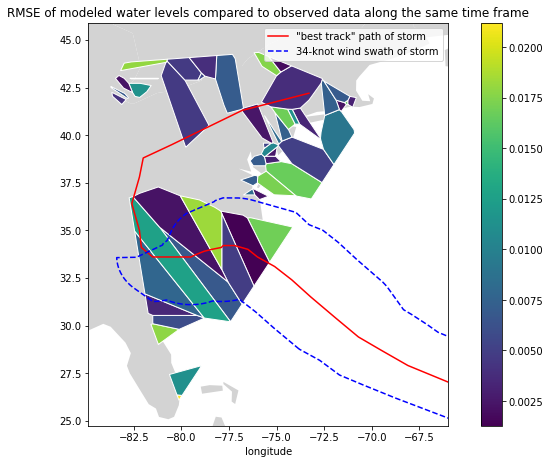

In [1739]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='rmse', edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['rmse'].min(),
        vmax=rmse_dataframe['rmse'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)

axis.set_title('RMSE of modeled water levels compared to observed data along the same time frame')
axis.legend()

### univariate spatial auto-correlation

In [1740]:
from libpysal.weights import Rook
import libpysal
from esda.moran import Moran
from splot.esda import plot_moran

geopandas.options.use_pygeos = True

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


#### rook connectivity

In [1741]:
rook_weights = Rook.from_dataframe(rmse_dataframe)

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 25, 26, 29.
  warnings.warn(message)


In [1742]:
%%script false --no- raise -error
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rook_weights.plot(
    rmse_dataframe.reset_index(),
    edge_kws=dict(color='r'),
    node_kws=dict(marker=''),
    ax=axis,
)

#### spatial lag of RMSE

In [1743]:
spatial_lag = libpysal.weights.lag_spatial(rook_weights, rmse_dataframe['rmse'])

In [1744]:
rmse_dataframe['spatial_lag'] = spatial_lag

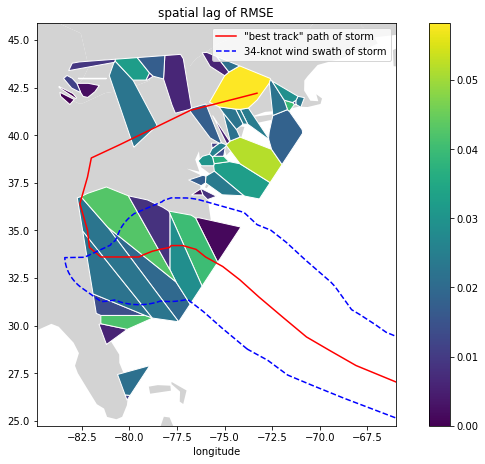

In [1745]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='spatial_lag', edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['spatial_lag'].min(),
        vmax=rmse_dataframe['spatial_lag'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)

axis.set_title('spatial lag of RMSE')
axis.legend()

#### global Moran's I

In [1746]:
rook_morans_i = Moran(
    rmse_dataframe[['rmse']].values,
    rook_weights,
)
rook_morans_i.I

('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 29, ' is an island (no neighbors)')


-0.22110798432601786

(<Figure size 864x533.981 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: -0.22', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (-0.22)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

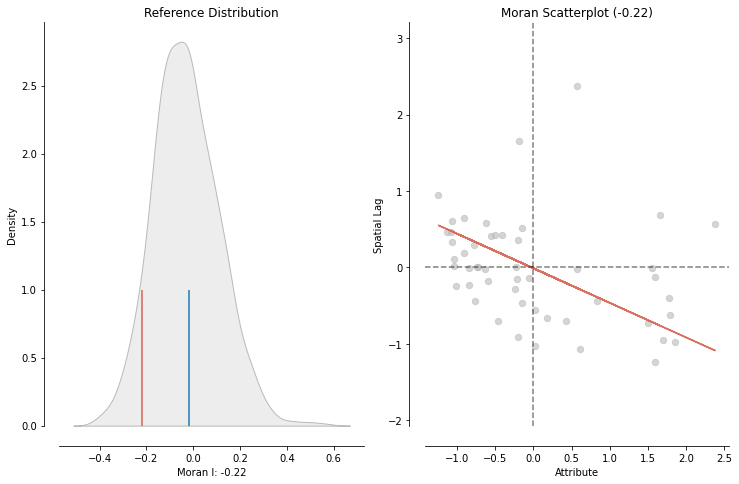

In [1747]:
plot_moran(
    rook_morans_i,
    zstandard=True,
    figsize=(12, 12 / 1.61803398875),
)

In [1748]:
rook_morans_i.p_sim

0.072

In [1749]:
rmse_dataframe['rook_morans_i_z'] = rook_morans_i.z

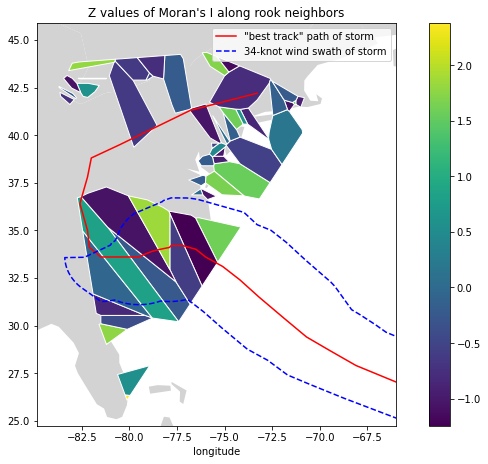

In [1750]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='rook_morans_i_z', edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['rook_morans_i_z'].min(),
        vmax=rmse_dataframe['rook_morans_i_z'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)

axis.set_title('Z values of Moran\'s I along rook neighbors')
axis.legend()

#### local G

In [1751]:
from esda.getisord import G_Local

In [1752]:
local_g = G_Local(rmse_dataframe['rmse'], rook_weights, transform='B')
local_g.Zs

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/esda/getisord.py:496: RuntimeWarning: invalid value encountered in true_divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CA

ValueError: cannot assign slice from input of different size

In [ ]:
rmse_dataframe['local_G_p'] = local_g.p_sim
rmse_dataframe['local_G_p']

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='local_G_p', edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['local_G_p'].min(),
        vmax=rmse_dataframe['local_G_p'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)
colorbar.set_label('local_G_p', rotation=270)

#### local G*

In [ ]:
local_g_star = G_Local(rmse_dataframe['rmse'], rook_weights, transform='B',star=True)
local_g_star.Zs

In [ ]:
rmse_dataframe['local_G*_p'] = local_g_star.p_sim
rmse_dataframe['local_G*_p']

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='local_G*_p', edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['local_G*_p'].min(),
        vmax=rmse_dataframe['local_G*_p'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)
colorbar.set_label('local_G*_p', rotation=270)